In [1]:
#autoreload
%load_ext autoreload
%autoreload 2

# Generate random data

In [2]:
import pandas as pd
import numpy as np
import itertools
np.random.seed(42)
# create a random dataset with 10 multiindex columns with binary values
index_tuples = list(itertools.product([0, 1], repeat=10))
values = np.random.randint(0, 101, size=len(index_tuples))
multi_index = pd.MultiIndex.from_tuples(index_tuples)
data = pd.Series(values, index=multi_index, name="count")

# Apply InfTDA

In [3]:
from InfTDA import inf_tda

# Define the privacy parameters
epsilon = 1.
delta = 1e-6
budget = (epsilon, delta)
# Sensitivity of the query (in this case each user contributes to 1 tuple)
contribution = 1  # how many tuples each user contributes to
privacy_type = "bounded"  # or "unbounded"
distinct_tuples = True  # or False if each user can contribute to multiple non-distinct tuples

# Run the algorithm
result_inf_tda: pd.Series = inf_tda(data=data,
                                    budget=budget,
                                    contribution=contribution,
                                    privacy_type=privacy_type,
                                    distinct_tuples=distinct_tuples)

# Apply Gaussian noise one time

In [4]:
import opendp as dp
from opendp.domains import vector_domain, atom_domain
from opendp.metrics import l2_distance
from opendp.measurements import make_gaussian
from opendp.prelude import enable_features

enable_features("contrib")


def make_gaussian_noise(d_in: float,
                        rho: float
                        ) -> dp.Measurement:
    """
    Return a Gaussian mechanism with rho (from zCDP)
    :param d_in: int -  l2 sensitivity
    :param rho: float - privacy budget (rho in zCDP)
    :return: Gaussian mechanism
    """
    # assert dtype is int or float
    assert rho > 0, f"Invalid rho budget: {rho}, must be > 0"

    input_space = vector_domain(atom_domain(T=int)), l2_distance(T=int)
    mechanism = make_gaussian(*input_space, scale=d_in / np.sqrt(2 * rho))
    return mechanism


def get_rho_from_budget(budget: tuple[float, float]) -> float:
    """
    Return rho (from zCDP) given epsilon and delta.

    :param budget: tuple[float, float] - (epsilon, delta) privacy budget
    :return: rho: float- rho privacy budget
    """
    assert budget[0] > 0, f"Invalid epsilon: {budget[0]}, must be > 0"
    assert 0 < budget[1] < 1, f"Invalid delta: {budget[1]}, must be in (0, 1)"
    assert type(budget[0]) == float, f"Invalid epsilon type: {type(budget[0])}, must be float"
    assert type(budget[1]) == float, f"Invalid delta type: {type(budget[1])}, must be float"

    epsilon = budget[0]
    delta = budget[1]
    return np.log(1 / delta) * (np.sqrt(1 + epsilon / np.log(1 / delta)) - 1) ** 2


rho = get_rho_from_budget(budget)
gaussian_mechanism = make_gaussian_noise(d_in=contribution,
                                         rho=rho)

In [5]:
result_gauss = pd.Series(
    gaussian_mechanism(data.to_numpy()),
    index=data.index,
    name=data.name
)
result_gauss.head()

0  0  0  0  0  0  0  0  0  0     43
                           1    104
                        1  0     17
                           1     67
                     1  0  0     65
Name: count, dtype: int64

# Analysis

In [6]:
import pandas as pd
import numpy as np

def get_max_abs_error(true_data: pd.Series, synth_data: pd.Series) -> np.ndarray:
    if true_data.index.nlevels != synth_data.index.nlevels:
        raise ValueError("The number of levels in the true data and synthetic data must be the same.")

    d = true_data.index.nlevels
    output = np.zeros(d)

    for k in range(d):
        levels = list(range(k + 1))
        true_k_hierarchy = true_data.groupby(level=levels).sum()
        synth_k_hierarchy = synth_data.groupby(level=levels).sum()

        # Align indices in one step
        true_k_hierarchy, synth_k_hierarchy = true_k_hierarchy.align(synth_k_hierarchy, fill_value=0)

        # Compute max absolute error
        output[k] = np.max(np.abs(true_k_hierarchy - synth_k_hierarchy))

    return output
max_abs_error_inf_tda = get_max_abs_error(data, result_inf_tda)
max_abs_error_gauss = get_max_abs_error(data, result_gauss)

# Plot

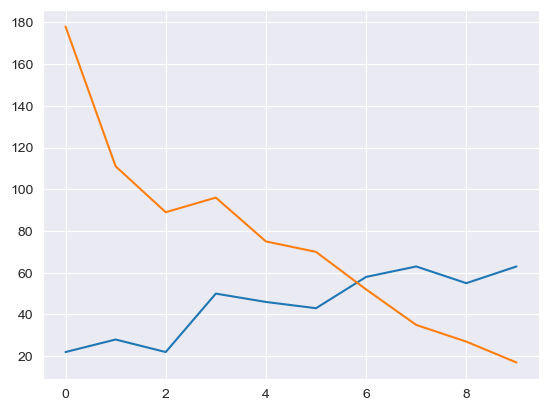

In [7]:
import matplotlib.pyplot as plt

plt.plot(max_abs_error_inf_tda)
plt.plot(max_abs_error_gauss)
plt.show()

# Do many runs

In [8]:
NUM_EXPERIMENTS = 100
records = []
for _ in range(NUM_EXPERIMENTS):
    # create a random dataset with 10 multiindex columns with binary values
    index_tuples = list(itertools.product([0, 1], repeat=10))
    values = np.random.randint(0, 101, size=len(index_tuples))
    multi_index = pd.MultiIndex.from_tuples(index_tuples)
    data = pd.Series(values, index=multi_index, name="count")

    # Run the algorithm
    result_inf_tda: pd.Series = inf_tda(data=data,
                                        budget=budget,
                                        contribution=contribution,
                                        privacy_type=privacy_type,
                                        distinct_tuples=distinct_tuples)
    max_abs_error_inf_tda = get_max_abs_error(data, result_inf_tda)
    for k in range(1, data.index.nlevels + 1):
        records.append({
            "mechanism": "InfTDA",
            "level": k,
            "max_abs_error": max_abs_error_inf_tda[k - 1],
        })

    # Apply Gaussian noise one time
    gaussian_mechanism = make_gaussian_noise(d_in=contribution,
                                             rho=rho)
    result_gauss = pd.Series(
        gaussian_mechanism(data.to_numpy()),
        index=data.index,
        name=data.name
    )
    max_abs_error_gauss = get_max_abs_error(data, result_gauss)
    for k in range(1, data.index.nlevels + 1):
        records.append({
            "mechanism": "gauss",
            "level": k,
            "max_abs_error": max_abs_error_gauss[k - 1],
        })


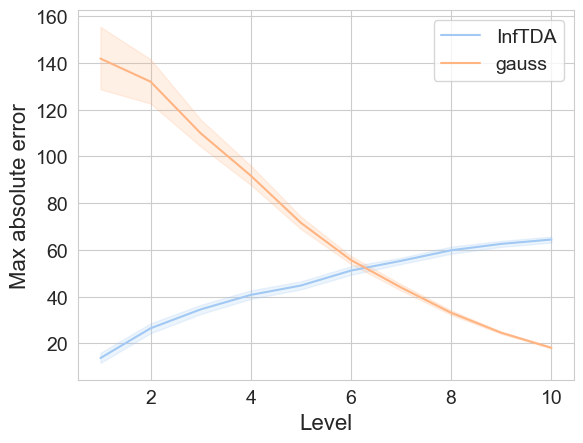

In [9]:
# Convert to DataFrame for seaborn
df = pd.DataFrame(records)
import seaborn as sns
sns.set_palette("pastel")
sns.set_style("whitegrid")
# plot
sns.lineplot(data=df, x="level", y="max_abs_error", hue="mechanism", errorbar=("ci", 95))
plt.xlabel("Level", fontsize=16)
plt.ylabel("Max absolute error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
